# Overview
- loglossのペナルティについてEDAしてみる
- 以下のふたつのtargetはtrainに1サンプルしかない
    - atp-sensitive_potassium_channel_antagonist
    - erbb2_inhibitor

# Const

In [1]:
NB = '007'
PATH_TRAIN = '../data_ignore/input/train_features.csv'
PATH_TRAIN_SCORED = '../data_ignore/input/train_targets_scored.csv'
PATH_TRAIN_NONSCORED = '../data_ignore/input/train_targets_nonscored.csv'
PATH_SUB = '../data_ignore/input/sample_submission.csv'
PATH_TEST = '../data_ignore/input/test_features.csv'
PATH_GROUP = '../data_ignore/output_nb/nb004/group.csv'
cp = ['#f8b195', '#f67280', '#c06c84', '#6c5b7b', '#355c7d']

# Import everything I need :)

In [ ]:
import os
from pprint import pprint
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fastprogress import progress_bar
from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import log_loss
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# My function

In [ ]:
def get_696_strategy_fold(group, n_splits, seed=0):
    '''nb004'''
    
    # group == 0 (all_target=0)の分解
    mask_0 = group['group'] == 0
    group_0 = group[mask_0]
    splitter = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
    df_fold_0 = pd.DataFrame()
    df_fold_0['fold'] = np.zeros(len(group_0)).astype(int)
    for i_fold, (idx_trn, idx_val)  in enumerate(splitter.split(group_0)):
        df_fold_0['fold'][idx_val] = int(i_fold + 1)

    # group != 0 の分解
    mask_not0 = group['group'] != 0
    group_not0 = group[mask_not0]
    splitter = GroupKFold(n_splits=n_splits)
    df_fold_not0 = pd.DataFrame()
    df_fold_not0['fold'] = np.zeros(len(group_not0)).astype(int)
    for i_fold, (idx_trn, idx_val)  in enumerate(splitter.split(group_not0, groups=group_not0['group'].values)):
        df_fold_not0['fold'][idx_val] = int(i_fold + 1)

    # fold情報の結合
    df_fold = pd.DataFrame()
    df_fold['sig_id'] = group['sig_id'].values
    df_fold['fold'] = np.zeros(len(group)).astype(int)
    df_fold['fold'][mask_0.values] = df_fold_0['fold'].values
    df_fold['fold'][mask_not0.values] = df_fold_not0['fold'].values
    return df_fold

In [ ]:
def mean_log_loss(y_true, y_pred):
    metrics = []
    for i, target in enumerate(targets.columns):
        metrics.append(log_loss(y_true[:, i], y_pred[:, i].astype(float), labels=[0,1]))
    return np.mean(metrics)

# Preparation

set

In [ ]:
sns.set()
pd.set_option('display.max_columns', 1000)
warnings.filterwarnings('ignore')

<br>

load datasets

In [ ]:
train_features = pd.read_csv(PATH_TRAIN)
train_targets = pd.read_csv(PATH_TRAIN_SCORED)
# train_nonscored = pd.read_csv(PATH_TRAIN_NONSCORED)
# sub = pd.read_csv(PATH_SUB)
test_features = pd.read_csv(PATH_TEST)

In [23]:
targets = train_targets.drop(['sig_id'], axis=1)

# EDA

手始めに、targetのうち、1個だけ1があるようにする

In [202]:
dummy_test_target = np.zeros(len(test_features)).astype(int)
dummy_test_pred = np.zeros(len(test_features))
dummy_test_target[:3] = 1
dummy_test_target, len(dummy_test_target)

(array([1, 1, 1, ..., 0, 0, 0]), 3982)

<br>

一定値埋めで評価してみる

In [212]:
const_val = 0
dummy_test_pred[:] = const_val
score = log_loss(dummy_test_target, dummy_test_pred)
print(f'const_val={const_val}, logloss={score:.6f}')

const_val = 1e-3
dummy_test_pred[:] = const_val
score = log_loss(dummy_test_target, dummy_test_pred)
print(f'const_val={const_val}, logloss={score:.6f}')

const_val=0, logloss=0.026021
const_val=0.001, logloss=0.006204


---> scoreにかなり差がある...

# public testで1になる回数が1~5になったと仮定した時に、どの一定値がもっともlossが低くなるかを計算してみる

In [213]:
%%time
n_log_space = 200
target_n_list = [1, 2, 3, 4, 5]

best_loss_dict = {}
log_space = np.logspace(-15, -0.1, n_log_space)
df_scores = pd.DataFrame(index=log_space)
for n_target in target_n_list:
    dummy_test_target = np.zeros(len(test_features)).astype(int)
    dummy_test_pred = np.zeros(len(test_features))
    dummy_test_target[:n_target] = 1
    
    best_loss = np.inf
    best_const_val = np.inf
    scores = []
    for const_val in log_space:
        dummy_test_pred[:] = const_val
        score = log_loss(dummy_test_target, dummy_test_pred)
        scores.append(score)
        if score < best_loss:
            best_loss = score
            best_const_val = const_val
    df_scores[f'n_target_{n_target}'] = scores
    best_loss_dict[f'n_target_{n_target}'] = {'best_const_val': best_const_val, 'best_loss': best_loss}

pprint(best_loss_dict)

{'n_target_1': {'best_const_val': 0.00024038342714283753,
                'best_loss': 0.0023330880858058833},
 'n_target_2': {'best_const_val': 0.00047907334729874505,
                'best_loss': 0.004318051855446088},
 'n_target_3': {'best_const_val': 0.0008035726106477336,
                'best_loss': 0.006172282724985029},
 'n_target_4': {'best_const_val': 0.0009547716114208065,
                'best_loss': 0.007939741175553723},
 'n_target_5': {'best_const_val': 0.0013478707263181178,
                'best_loss': 0.00964596775580699}}
CPU times: user 829 ms, sys: 2.33 ms, total: 832 ms
Wall time: 830 ms


<br>

color

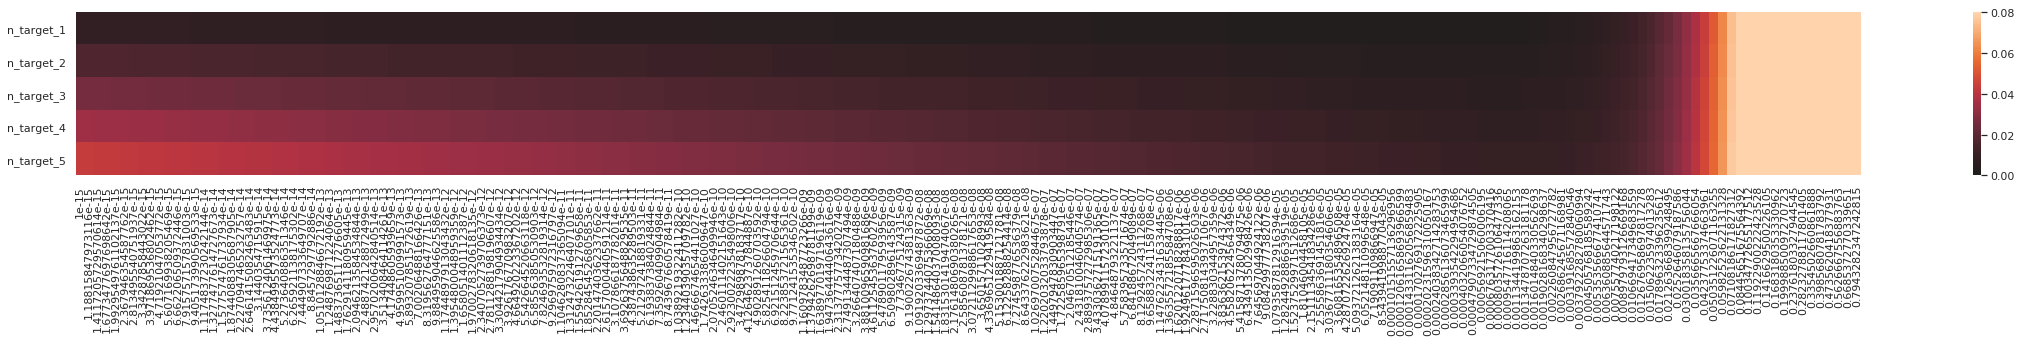

In [214]:
df = df_scores.T
plt.figure(figsize=(40, 3))
sns.heatmap(df,
            xticklabels=df.columns,
            yticklabels=df.index,
            vmax=0.08,
            vmin=0,
            center=0)

<br>

plot

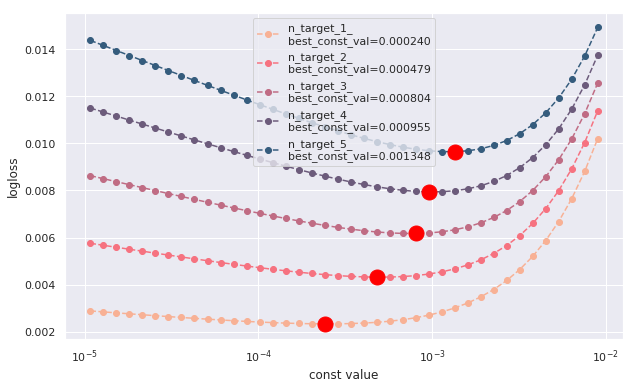

In [215]:
x = df_scores.index
mask = (1e-5 < x) & (x < 1e-2)

plt.figure(figsize=(10, 6))
for n in target_n_list:
    name = f'n_target_{n}'
    best_const_val = best_loss_dict[name]['best_const_val']
    best_loss = best_loss_dict[name]['best_loss']
    
    plt.plot(df_scores[name][mask], '--o', color=cp[n-1], label=f'{name}_\nbest_const_val={best_const_val:.6f}')
    plt.plot(best_const_val, best_loss, 'o', color='red', markersize=15)
plt.xscale('log')
plt.xlabel('const value')
plt.ylabel('logloss')
plt.legend()

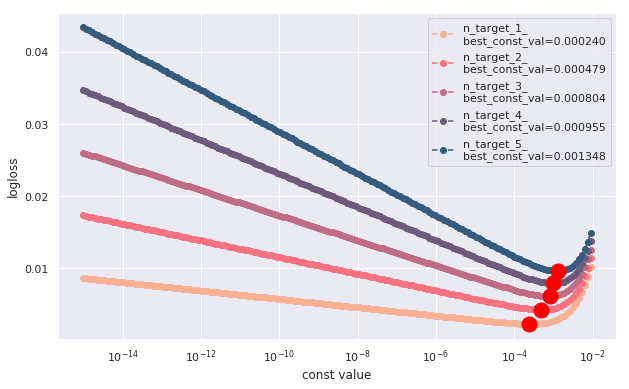

In [223]:
x = df_scores.index
mask = (0 < x) & (x < 1e-2)

plt.figure(figsize=(10, 6))
for n in target_n_list:
    name = f'n_target_{n}'
    best_const_val = best_loss_dict[name]['best_const_val']
    best_loss = best_loss_dict[name]['best_loss']
    
    plt.plot(df_scores[name][mask], '--o', color=cp[n-1], label=f'{name}_\nbest_const_val={best_const_val:.6f}')
    plt.plot(best_const_val, best_loss, 'o', color='red', markersize=15)
plt.xscale('log')
plt.xlabel('const value')
plt.ylabel('logloss')
plt.legend()